# Bert Model Fine-tuning

This notebook primarily utilizes the state-of-the-art (SOTA) Google BERT model, originally designed to learn how to order shuffled sentences within a paragraph. While most use cases focus on classification and Named Entity Recognition (NER), we often need to fine-tune this model to suit our specific needs.

One important consideration is that the context input length is limited to less than 512 tokens due to the model’s structural constraints. Additionally, high-quality training data is essential to achieve good generalization. We also test other spliting of dataset and we obtain the similar accuracy (Originally set to 42) but different trace of training loss. This highlights that the model learns something from the data.

Model used: BERT-base-multilingual-uncased

This [slides](https://docs.google.com/presentation/d/165GxBIZ-Jxk8uaEKK9h02GtFsKsCCQdm8ouar2JkCKU/edit?usp=sharing) has more details see here. 

In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
from nltk.corpus import stopwords
import re

import torch
import torch.nn as nn
from torch.utils.data import (
    TensorDataset,
    DataLoader,
    RandomSampler,
    SequentialSampler,
    random_split,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import (
    BertForSequenceClassification,
    AdamW,
    BertConfig,
    BertTokenizer,
    get_linear_schedule_with_warmup,
)
import os

# Specify your cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/home/lujun_li/anaconda3/envs/causalLLM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=0)

## Data preprocessing

In [107]:
################MT################

folder_path = "/home/lujun_li/projects/temperature_eval/data/MT/"
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)
df = df[~df["spbleu"].isna()]
df["Temperature"] = df["Temperature"].astype(float).round(1)
df["performance_score"] = df["spbleu"]
df["ability"] = "MT"
df_MT = df[
    ["initial_prompt", "model_name", "performance_score", "Temperature", "ability"]
]

############################SUM############################
folder_path = "/home/lujun_li/projects/temperature_eval/data/SUM"
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)
df = df[~df["rouge_l_fmeasure"].isna()]
df["Temperature"] = df["Temperature"].astype(float).round(1)
df["performance_score"] = df["rouge_l_fmeasure"]
df["ability"] = "SUM"
df_SUM = df[
    ["initial_prompt", "model_name", "performance_score", "Temperature", "ability"]
]

#############################CT############################

from langchain.prompts import PromptTemplate

folder_path = "/home/lujun_li/projects/temperature_eval/data/CT"
all_dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        all_dfs.append(df)


def label_function(x):
    if str(x).startswith("Yes"):
        return True
    elif str(x).startswith("No"):
        return False
    else:
        return None


df = pd.concat(all_dfs, ignore_index=True)
df["label"] = df["OpenAI_response"].apply(label_function)
df = df[~df["label"].isna()]
df = df[df["Temperature"] != "temperature"]
df["Temperature"] = df["Temperature"].astype(float).round(1)


template = """
Instruction: Write a New Yorker-style story given the plot below. Make sure it is at least 500 words. Directly start with the story, do not say things like 'Here's the story [...]'
Input: 
Current plot: {current_plot}
"""

# Create a PromptTemplate
prompt = PromptTemplate(input_variables=["current_plot"], template=template)

df["initial_prompt"] = df["plot"].apply(lambda x: prompt.format(current_plot=x))

df = (
    df.groupby(["initial_prompt", "Temperature", "model_name"])["label"]
    .mean()
    .round(2)
    .reset_index()
)

df["performance_score"] = df["label"]
df["ability"] = "CT"
df_CT = df[
    ["initial_prompt", "model_name", "performance_score", "Temperature", "ability"]
]


#############################IF############################

folder_path = "/home/lujun_li/projects/temperature_eval/data/IF"
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        all_dfs.append(df)
model_map = {
    "Llama-2-7b-chat-hf": 0,
    "Llama-2-13b-chat-hf": 1,
    "Llama-2-70b-chat-hf": 2,
    "Meta-Llama-3-8B-Instruct": 3,
    "Meta-Llama-3-70B-Instruct": 4,
    "Mistral-7B-Instruct-v0.2": 5,
    "Mixtral-8x7B-Instruct-v0.1": 6,
}
df = pd.concat(all_dfs, ignore_index=True)
df["model_encoded"] = df["model_name"].map(model_map)
df["Temperature"] = df["Temperature"].astype(float).round(1)
df = df[~df["eval"].str.contains("None", na=False)]


def count_true_false(string):
    string_lower = string.lower()
    count_true = string_lower.count("true")
    count_false = string_lower.count("false")
    return count_true, count_false


df[["true_count", "false_count"]] = df["eval"].apply(count_true_false).apply(pd.Series)
df["DRFR"] = df["true_count"] / (df["true_count"] + df["false_count"])
df["performance_score"] = df["DRFR"]
df["ability"] = "IF"
df_IF = df[
    ["initial_prompt", "model_name", "performance_score", "Temperature", "ability"]
]

#############################ICL############################

import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

folder_path = "/home/lujun_li/projects/temperature_eval/data/ICL"
output_photo_name = f"ICL_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)


df = pd.concat(all_dfs, ignore_index=True)
df["Temperature"] = df["Temperature"].astype(float).round(1)
df = df[df["dataset_name"] == "trec"]
df["performance_score"] = df["classification_score"].round(2)
df["ability"] = "ICL"
df_ICL = df[
    ["initial_prompt", "model_name", "performance_score", "Temperature", "ability"]
]

#############################CR############################

import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

folder_path = "/home/lujun_li/projects/temperature_eval/data/CR"

all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)
df["Temperature"] = df["Temperature"].astype(float).round(1)


def string_to_boolean(s):
    s_stripped = s.strip("[]")
    return s_stripped.lower() == "true"


df["eval"] = df["eval"].apply(lambda x: string_to_boolean(x))
df["eval"] = df["eval"].apply(lambda x: 1 if x else 0)

df["performance_score"] = df["eval"].round(2)
df["ability"] = "CR"
df_CR = df[
    ["initial_prompt", "model_name", "performance_score", "Temperature", "ability"]
]

In [108]:
df = pd.concat([df_CR, df_CT, df_ICL, df_IF, df_MT, df_SUM], ignore_index=True)

In [109]:
dataset_path = (
    "/home/lujun_li/projects/temperature_eval/data/all_data_for_bert_training.csv"
)

df.to_csv(dataset_path, index=False)

In [113]:
df

,initial_prompt,model_name,performance_score,Temperature,ability
0,Instruction: You are a conscientious assistant...,Meta-Llama-3-70B-Instruct,0,0.1,CR
1,Instruction: You are a conscientious assistant...,Meta-Llama-3-70B-Instruct,1,0.1,CR
2,Instruction: You are a conscientious assistant...,Meta-Llama-3-70B-Instruct,1,0.1,CR
3,Instruction: You are a conscientious assistant...,Meta-Llama-3-70B-Instruct,1,0.1,CR
4,Instruction: You are a conscientious assistant...,Meta-Llama-3-70B-Instruct,1,0.1,CR
...,...,...,...,...,...
83158,\nRole: You are a writer who is good at summar...,Meta-Llama-3-8B-Instruct,0.238095,1.9,SUM
83159,\nRole: You are a writer who is good at summar...,Meta-Llama-3-8B-Instruct,0.291971,1.9,SUM
83160,\nRole: You are a writer who is good at summar...,Meta-Llama-3-8B-Instruct,0.321429,1.9,SUM
83161,\nRole: You are a writer who is good at summar...,Meta-Llama-3-8B-Instruct,0.285714,1.9,SUM


## Data For Training

In [114]:
# Load the dataset from a CSV file
dataset = pd.read_csv(dataset_path)

# Convert the 'Rappel' column to a categorical type
dataset["ability"] = dataset["ability"].astype("category")

# Encode the categorical 'Rappel' column as numerical codes
dataset["ability"] = dataset["ability"].cat.codes

# Extract the email content and labels into separate variables
texts = dataset.initial_prompt.values
labels = dataset.ability.values

In [118]:
# Define the path to the pre-trained model
model = "/home/lujun_li/models/bert-base-multilingual-uncased"

# Initialize the tokenizer from the pre-trained model, with lowercasing enabled
tokenizer = BertTokenizer.from_pretrained(model, do_lower_case=True)

# Get the maximum token length supported by the tokenizer
max_token_length = tokenizer.model_max_length

# Initialize a variable to keep track of the maximum length of tokenized input
max_len = 0

# Iterate over each text in the dataset
for text in texts:
    # Tokenize the text and add special tokens
    input_ids = tokenizer.encode(text, add_special_tokens=True, truncation=True)
    # Update max_len with the length of the current tokenized input if it's greater than the current max_len
    max_len = max(max_len, len(input_ids))

# Determine the maximum padding length
if max_len < max_token_length:
    max_padding = max_len
else:
    max_padding = max_token_length

max_padding  # Need to padding to 512

KeyboardInterrupt: 

In [116]:
input_ids = []
attention_masks = []

for text in texts:
    # `encode_plus` (1) Tokenize the sentence. (2) Prepend the `[CLS]` token to the start. (3) Append the `[SEP]` token to the end.
    #  (4) Map tokens to their IDs. (5) Pad or truncate the sentence to `max_length` (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
        text,  # Sentence to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=max_padding,  # Pad & truncate all sentences.
        pad_to_max_length=True,
        return_attention_mask=True,  # Construct attn. masks.
        return_tensors="pt",  # Return pytorch tensors.
    )

    input_ids.append(encoded_dict["input_ids"])
    attention_masks.append(encoded_dict["attention_mask"])

# Convert the lists into tensors. [Samples, max_length]
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels).to(torch.int64)
labels = torch.nn.functional.one_hot(
    labels
).float()  # Change to Float in order to calcualte Loss [Samples, 2]

NameError: name 'tokenizer' is not defined

In [38]:
# Combine the training inputs into a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Set the random seed for reproducibility and shuffle the dataset
torch.manual_seed(40)  # Orginally set to 42 for training
sample_indices = torch.randperm(len(dataset))
test_dataset = torch.utils.data.Subset(dataset, sample_indices)

# Calculate the sizes for training and validation datasets
train_size = int(0.6 * len(test_dataset))
val_size = len(test_dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(test_dataset, [train_size, val_size])

# Print the number of samples in the training and validation sets
print("{:>5,} training samples".format(train_size))
print("{:>5,} validation samples".format(val_size))

# Dataset preparation
batch_size = 32
train_dataloader = DataLoader(
    train_dataset,  # The training samples.
    sampler=RandomSampler(train_dataset),  # Select batches randomly
    batch_size=batch_size,  # Trains with this batch size.
)

validation_dataloader = DataLoader(
    val_dataset,  # The validation samples.
    sampler=SequentialSampler(val_dataset),  # Pull out batches sequentially.
    batch_size=batch_size,  # Evaluate with this batch size.
)

3,688 training samples
2,460 validation samples


## Training Engine Initialization

In [39]:
model = BertForSequenceClassification.from_pretrained(
    model,  # Use the 12-layer BERT model, with an uncased vocab.
    num_labels=2,  # The number of output labels--2 for binary classification.
    output_attentions=False,  # Whether the model returns attentions weights.
    output_hidden_states=False,  # Whether the model returns all hidden-states.
)

model = model.to(device)

optimizer = AdamW(
    model.parameters(),
    lr=5e-6,  # args.learning_rate - default is 5e-5, our notebook had 2e-5
    eps=1e-8,  # args.adam_epsilon  - default is 1e-8.
)

# Number of training epochs.
epochs = 20

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler. (This is important to decrease learning while training)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,  # Default value in run_glue.py
    num_training_steps=total_steps,
)


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = np.argmax(labels, axis=1).flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/llama/Personal_Directories/srb/binary_classfication/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/llama/Personal_Directories/srb/env_minicpm_vllm/lib64/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Start Training

In [41]:
seed_val = 43  # Set the seed value for reproducibility originally 42
random.seed(seed_val)  # Set the seed for the Python random module
np.random.seed(seed_val)  # Set the seed for NumPy's random number generator
torch.manual_seed(seed_val)  # Set the seed for PyTorch's random number generator
torch.cuda.manual_seed_all(
    seed_val
)  # Set the seed for all CUDA (GPU) operations in PyTorch


training_stats = []  # Initialize an empty list to store training statistics
total_t0 = time.time()  # Measure the total training time for the whole run.

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print("======== Epoch {:} / {:} ========".format(epoch_i + 1, epochs))
    print("Training...")
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels,
        )
        loss = output.loss  # Loss is calculate by forwarding

        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            output = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
        loss = output.loss

        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, f"bert_model_target_")
        best_eval_accuracy = avg_val_accuracy
    torch.save(model, f"bert_model_target_{epoch_i}")
    # print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    # print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            "epoch": epoch_i + 1,
            "Training Loss": avg_train_loss,
            "Valid. Loss": avg_val_loss,
            "Valid. Accur.": avg_val_accuracy,
            "Training Time": training_time,
            "Validation Time": validation_time,
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.41
  Training epcoh took: 0:00:28

Running Validation...
  Accuracy: 0.90

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.31
  Training epcoh took: 0:00:28

Running Validation...
  Accuracy: 0.93

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.25
  Training epcoh took: 0:00:28

Running Validation...
  Accuracy: 0.94

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.21
  Training epcoh took: 0:00:28

Running Validation...
  Accuracy: 0.95

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.16
  Training epcoh took: 0:00:28

Running Validation...
  Accuracy: 0.95

======== Epoch 6 / 20 ========
Training...

  Average training loss: 0.14
  Training epcoh took: 0:00:28

Running Validation...
  Accuracy: 0.92

======== Epoch 7 / 20 ========
Training...

  Average training loss: 0.11
  Training epcoh took: 0:00:28

Running Validatio

## Test on single email

In [70]:
email = """

From: "Elton Silva" <Elton.Silva@post.lu>
Sent: mercredi 6 octobre 2021 21:49:23
To: "Foyer Assurances" <sinistres-habitation@foyer.lu>
Cc: "Sandra Dias" <sandra.dias@foyer.lu>
Subject: Re: Groupe Foyer - Sinistre 3158166 - Contrat 0020586108 00001 - MOZAIK
Soyez vigilant.e !
Ce message est envoyé par un correspondant externe.
Veuillez ne pas cliquer sur des liens ou des pièces jointes sauf sice message est sollicité et que vous avezacquis l'assurance qu'il
provient d'une source sûre.
Un doute sur son origine ? Prévenezla hotline.
Bonjour,
N’ayant toujours pas obtenude remboursement, je me permets de relancer la demande annexe.
Cordialement
EltonSilva
Responsable Jumper&Planification
ConseillerCommercial
RéseauVente
Tel. :+352 2462-1
elton.silva@post.lu
Telecom
1, rue Emile Bian
L-2996 Luxembourg
[Link Deleted] / Autorisationd'établissement n° 00116288 / 55
POSTLuxembourgest acteur dudéveloppement durable
Ce message et toutes les pièces jointes (ci-après le "message") sont établis à l'intentionexclusive de ses destinataires et sont confidentiels.
Sivous recevezce message par erreur, mercide le détruire et d'enavertir immédiatement l'expéditeur.
Toute utilisationde ce message nonconforme à sa destination, toute diffusionoutoute publication, totale oupartielle, est interdite, saufautorisation
expresse.
Internet ne permettant pas d'assurer l'intégrité de ce message, POSTLuxembourgdécline toute responsabilité autitre de ce message, dans l'hypothèse
oùilaurait été modifié.
Le 24 sept. 2021 à 14:23, EltonSilva <Elton.Silva@post.lu> a écrit :
​ Bonjour,
Veuilleztrouver enannexe, la facture finale.
Cordialement
EltonSilva
Responsable Jumper &Planification
Conseiller Commercial
RéseauVente
Tel. :+352 2462-1
elton.silva@post.lu
Telecom
1, rue Emile Bian
L-2996 Luxembourg
[Link Deleted] / Autorisationd'établissement n° 00116288/55
POST Luxembourg est acteur du développement durable
Ce message et toutes les pièces jointes (ci-après le "message") sont établis à l'intentionexclusive de ses destinataires et sont confidentiels.
Sivous recevezce message par erreur, mercide le détruire et d'enavertir immédiatement l'expéditeur.
Toute utilisationde ce message nonconforme à sa destination, toute diffusionoutoute publication, totale oupartielle, est interdite, sauf
autorisationexpresse.
Internet ne permettant pas d'assurer l'intégrité de ce message, POSTLuxembourgdécline toute responsabilité autitre de ce message,
dans l'hypothèse oùilaurait été modifié.
Le 21 sept. 2021 à 09:52, Foyer Assurances <sinistres-habitation@foyer.lu> a écrit :
ATTENTION : Ce mail provient de l'extérieur de Post. Ne cliquez pas sur les liens ou n'ouvrez pas les pièces jointes à moins de connaitre l'expéditeur et d'être sûr que
le contenu est inoffensif. En cas de doute sur son origine ou si vous pensez qu'il est suspect, nous vous prions de rapporter cet évènement par email à
cybersos@post.lu.
Madame, Monsieur,
Vous trouvezci-dessous uncourrier sous format PDF, le cas échéant avec ses annexes, vous concernant.

"""

In [71]:
input_ids = []
attention_masks = []
texts = [email]
for text in texts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
        text,  # Sentence to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=max_padding,  # Pad & truncate all sentences.
        pad_to_max_length=True,
        return_attention_mask=True,  # Construct attn. masks.
        return_tensors="pt",  # Return pytorch tensors.
    )

    input_ids.append(encoded_dict["input_ids"])
    attention_masks.append(encoded_dict["attention_mask"])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor([[0, 1]]).to(torch.int64)

In [72]:
import torch

model = torch.load(
    "/home/llama/Personal_Directories/srb/binary_classfication/fine-tuning-bert/models_finetuning_second/bert_model_target_19"
)

# Set the model to evaluation mode
model.eval()

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded and set to evaluation mode.")
model.eval()

# Tracking variables
total_eval_accuracy = 0
best_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0
# Evaluate data for one epoch
b_input_ids = input_ids.to(device)
b_input_mask = attention_masks.to(device)
b_labels = labels.to(device)
# Tell pytorch not to bother with constructing the compute graph during
# the forward pass, since this is only needed for backprop (training).
with torch.no_grad():
    output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

logits = output.logits
logits = logits.detach().cpu().numpy()
label_ids = b_labels.to("cpu").numpy()
pred_flat = np.argmax(logits, axis=1).flatten()
labels_flat = np.argmax(label_ids, axis=1).flatten()

/tmp/ipykernel_3547319/4100754386.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/home/llama/Personal_Directories/srb/binary_classfication/fine-tuni

Model loaded and set to evaluation mode.


This results is correct but when we change something, prediction changed but we cannot explain

In [74]:
print(f"pred_flat : {pred_flat}")
print(f"labels_flat : {labels_flat}")

pred_flat : [1]
labels_flat : [1]


## Testing On All datasets for summarizations

In [76]:
import os


def list_files_in_folder(folder_path):
    # List all files in the given folder
    files = os.listdir(folder_path)
    return files


# We use all data for seeting the global results
all_dataloader = DataLoader(
    test_dataset,  # test_dataset(whole dataset), train_dataset (0.6 whole dataset),  val_dataset (rest),
    sampler=RandomSampler(train_dataset),  # Select batches randomly
    batch_size=batch_size,  # Trains with this batch size.
)

folder_path = "models_finetuning_second/"
models = list_files_in_folder(folder_path)
accuracy_list = []
epochs_list = []
for model_path in models:
    model = torch.load(folder_path + "/" + model_path)
    device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    # Tracking variables
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in all_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            output = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
        loss = output.loss

        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(all_dataloader)
    print("Global Accuracy: {0:.2f}".format(avg_val_accuracy))
    accuracy_list.append(avg_val_accuracy)
    epochs_list.append(model_path.split("_")[-1])

/tmp/ipykernel_3547319/2751142205.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(folder_path+"/"+model_path)


Global Accuracy: 0.89
Global Accuracy: 0.93
Global Accuracy: 0.94
Global Accuracy: 0.96
Global Accuracy: 0.97
Global Accuracy: 0.95
Global Accuracy: 0.98
Global Accuracy: 0.98
Global Accuracy: 0.98
Global Accuracy: 0.97
Global Accuracy: 0.97
Global Accuracy: 0.97
Global Accuracy: 0.98
Global Accuracy: 0.98
Global Accuracy: 0.98
Global Accuracy: 0.98
Global Accuracy: 0.98
Global Accuracy: 0.98
Global Accuracy: 0.98
Global Accuracy: 0.98


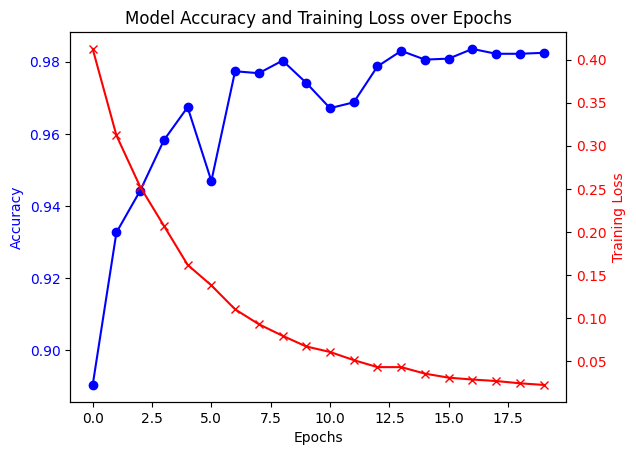

In [77]:
import matplotlib.pyplot as plt

training_loss = []
for training_stat in training_stats:
    training_loss.append(float(training_stat["Training Loss"]))

epochs = [int(epoch) for epoch in epochs_list]
fig, ax1 = plt.subplots()

# Plot accuracy on the first y-axis
ax1.plot(epochs, accuracy_list, "b-o", label="Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy", color="b")
ax1.tick_params(axis="y", labelcolor="b")

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(epochs, training_loss, "r-x", label="Training Loss")
ax2.set_ylabel("Training Loss", color="r")
ax2.tick_params(axis="y", labelcolor="r")

# Adding title
plt.title("Model Accuracy and Training Loss over Epochs")

# Display the plot
plt.show()

## Test on one single checkpoint model

You can use this block to test different checkpoint during training to test the model

In [ ]:
import os


def list_files_in_folder(folder_path):
    # List all files in the given folder
    files = os.listdir(folder_path)
    return files


folder_path = "models_finetuning_second/"
models = list_files_in_folder(folder_path)
accuracy_list = []
epochs_list = []
model = torch.load(folder_path + "/" + "bert_model_target_19")
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
# Tracking variables
total_eval_accuracy = 0
best_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0
# Evaluate data for one epoch
true_labels = []
predictions = []

for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        output = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels,
        )

    logits = output.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to("cpu").numpy()

    # Store predictions and true labels
    predictions.extend(np.argmax(logits, axis=1))
    true_labels.extend(np.argmax(label_ids, axis=1))

report = classification_report(
    true_labels, predictions, target_names=["Reminder", "Not Reminder"]
)
# Report the final accuracy for this validation run.
avg_val_accuracy = total_eval_accuracy / len(all_dataloader)
print("Global Accuracy: {0:.2f}".format(avg_val_accuracy))
accuracy_list.append(avg_val_accuracy)
epochs_list.append(model_path.split("_")[-1])